In [26]:
import sys
import os
import ast
import wfdb

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

import sklearn.metrics

from sklearn.preprocessing import StandardScaler

sns.set_style('darkgrid')

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [27]:
PATH_TO_DATA = '../data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'

ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x: ast.literal_eval(x))
ECG_df.patient_id = ECG_df.patient_id.astype(int)
ECG_df.nurse = ECG_df.nurse.astype('Int64')
ECG_df.site = ECG_df.site.astype('Int64')
ECG_df.validated_by = ECG_df.validated_by.astype('Int64')

ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709,56.0,1,NaN,63.0,2,0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243,19.0,0,NaN,70.0,2,0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372,37.0,1,NaN,69.0,2,0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014,24.0,0,NaN,82.0,2,0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448,19.0,1,NaN,70.0,2,0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67.0,1,NaN,NaN,1,2,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703,93.0,0,NaN,NaN,1,2,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311,59.0,1,NaN,NaN,1,2,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [28]:
ECG_df.strat_fold.value_counts().sort_index()

strat_fold
1     2177
2     2184
3     2194
4     2175
5     2176
6     2178
7     2178
8     2179
9     2193
10    2203
Name: count, dtype: int64

In [29]:
SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP_df = SCP_df[SCP_df.diagnostic == 1]

In [30]:
ECG_df.scp_codes

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21837, dtype: object

In [31]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in SCP_df.index and scp[k] > 0.0:
            res.add(SCP_df.loc[k].diagnostic_class)
    return list(res)
                    
ECG_df['scp_classes'] = ECG_df.scp_codes.apply(diagnostic_class)

In [32]:
ECG_df.scp_classes.value_counts()

scp_classes
[NORM]                 9111
[MI]                   2554
[STTC]                 2393
[CD]                   1730
[CD, MI]               1324
[STTC, HYP]             772
[STTC, MI]              586
[HYP]                   547
[]                      420
[NORM, CD]              410
[STTC, MI, HYP]         359
[CD, HYP]               304
[STTC, CD]              250
[CD, STTC]              201
[MI, HYP]               186
[CD, STTC, HYP]         127
[CD, MI, HYP]           123
[CD, STTC, MI]          105
[CD, STTC, MI, HYP]     104
[STTC, CD, MI]           96
[STTC, CD, HYP]          80
[STTC, CD, MI, HYP]      48
[STTC, NORM, CD]          2
[NORM, CD, HYP]           2
[NORM, HYP]               2
[NORM, CD, MI, HYP]       1
Name: count, dtype: int64

# Loading ECG waveforms

In [33]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        filenames = df.filename_lr
    else:
        filenames = df.filename_hr

    data = []
    for f in filenames:
        try:
            data.append(wfdb.rdsamp(os.path.join(path, f)))
        except Exception as e:
            continue

    data = np.array([signal for signal, meta in data])
    return data


In [ ]:
sampling_rate = 100
ECG_data = load_raw_data(ECG_df, sampling_rate, PATH_TO_DATA)
print(ECG_data.shape)

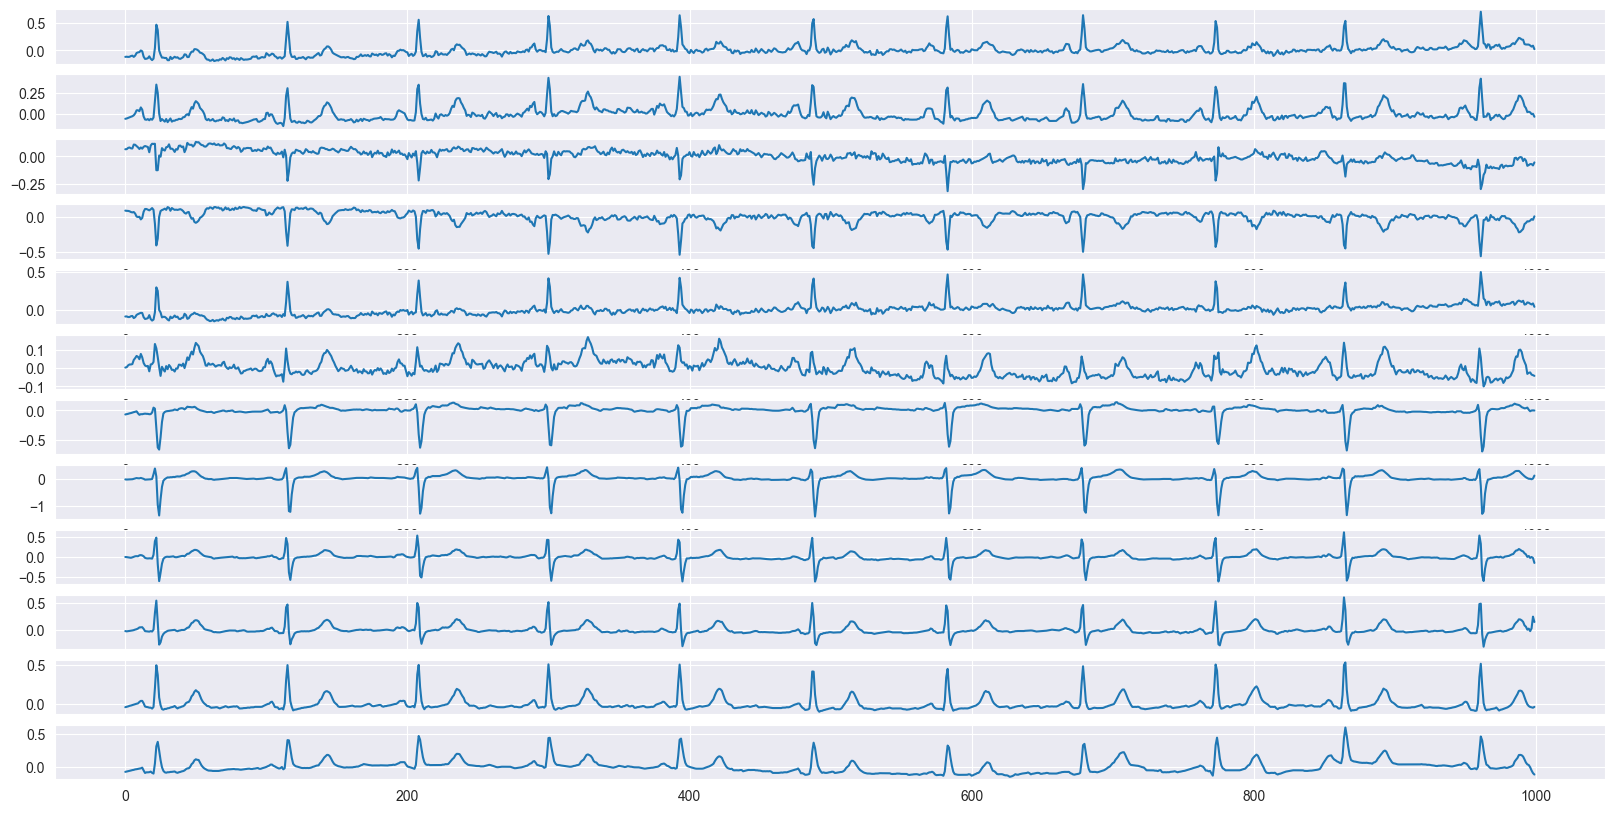

In [ ]:
sample = ECG_data[0]
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20,10))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
plt.show()

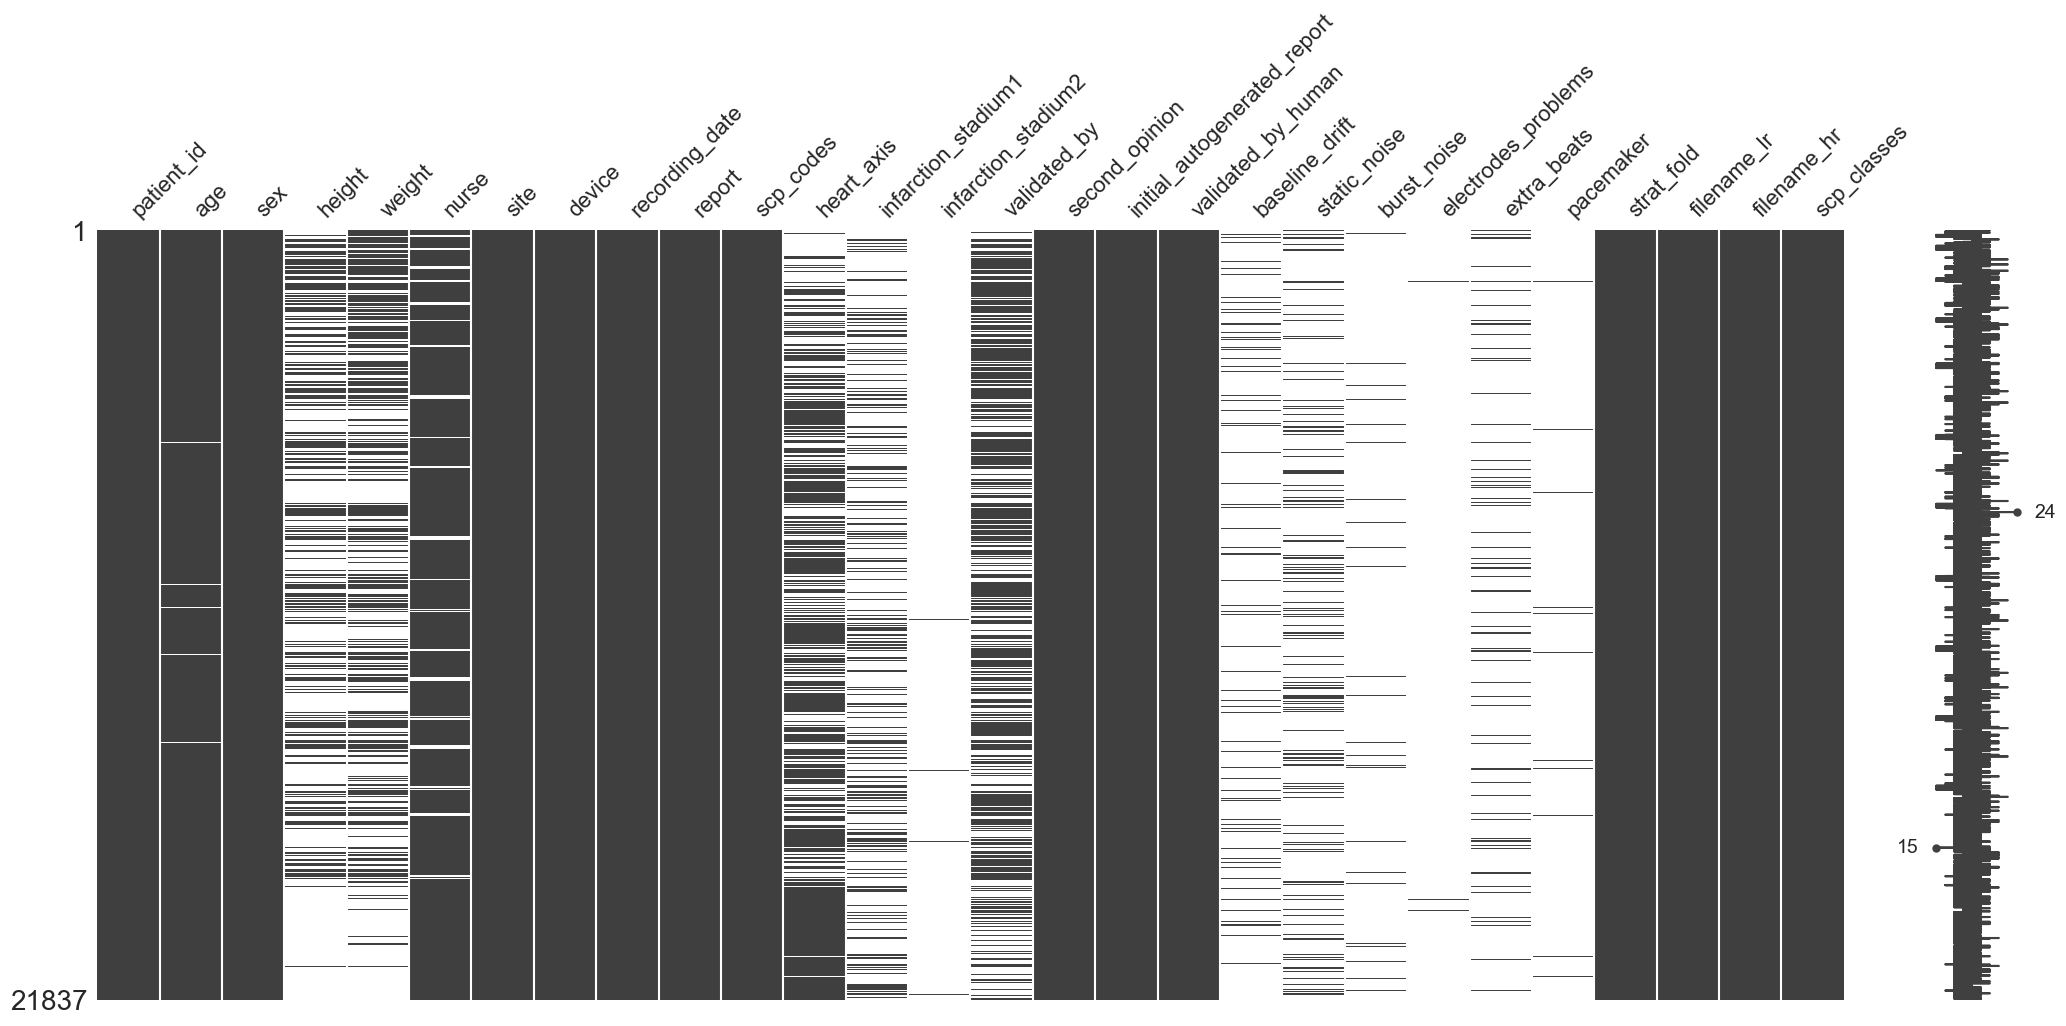

In [ ]:
import missingno as msno

msno.matrix(ECG_df)
plt.show()

In [ ]:
ECG_df[[col for col in ECG_df.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

patient_id                      18885
age                                94
sex                                 2
height                             77
weight                            127
nurse                              12
site                               51
device                             11
recording_date                  21813
report                           9883
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    321
static_noise                      124
burst_noise                       103
electrodes_problems                14
extra_beats                       128
pacemaker                           4
strat_fold                         10
filename_lr                     21837
filename_hr                     21837
dtype: int64

## Dataset X - metadata

In [ ]:
X = pd.DataFrame(index=ECG_df.index)

X['age'] = ECG_df.age
X.age.fillna(0, inplace=True)

X['sex'] = ECG_df.sex.astype(float)
X.sex.fillna(0, inplace=True)

X['height'] = ECG_df.height
X.loc[X.height < 50, 'height'] = np.nan
X.height.fillna(0, inplace=True)

X['weight'] = ECG_df.weight
X.weight.fillna(0, inplace=True)

X['infarction_stadium1'] = ECG_df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ECG_df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

X

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,pacemaker
ecg_id,,,,,,,
1,56.0,1.0,0.0,63.0,0.0,0.0,0.0
2,19.0,0.0,0.0,70.0,0.0,0.0,0.0
3,37.0,1.0,0.0,69.0,0.0,0.0,0.0
4,24.0,0.0,0.0,82.0,0.0,0.0,0.0
5,19.0,1.0,0.0,70.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
21833,67.0,1.0,0.0,0.0,0.0,0.0,0.0
21834,93.0,0.0,0.0,0.0,4.0,0.0,0.0
21835,59.0,1.0,0.0,0.0,0.0,0.0,0.0


## Dataset Y - ECG waveforms

In [ ]:
Y = ECG_data

Y.shape

(21286, 1000, 12)

## Dataset Z - classification classes

In [ ]:
Z = pd.DataFrame(0, index=ECG_df.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in ECG_df.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


In [ ]:
Z.sum()

NORM    9528
MI      5486
STTC    5123
CD      4907
HYP     2655
dtype: int64

## Division of datasets into training, validation and testing subsets

In [ ]:
X_train, Y_train, Z_train = X[ECG_df.strat_fold <= 8],  ECG_data[X[ECG_df.strat_fold <= 8].index - 1],  Z[ECG_df.strat_fold <= 8]
X_valid, Y_valid, Z_valid = X[ECG_df.strat_fold == 9],  ECG_data[X[ECG_df.strat_fold == 9].index - 1],  Z[ECG_df.strat_fold == 9]
X_test,  Y_test,  Z_test  = X[ECG_df.strat_fold == 10], ECG_data[X[ECG_df.strat_fold == 10].index - 1], Z[ECG_df.strat_fold == 10]

print(f"Training sets:   X_train={X_train.shape}  Y_train={Y_train.shape}  Z_train={Z_train.shape}")
print(f"Validation sets: X_valid={X_valid.shape}   Y_valid={Y_valid.shape}   Z_valid={Z_valid.shape}")
print(f"Test sets:       X_test ={X_test.shape}   Y_test={Y_test.shape}    Z_test={Z_test.shape}")

IndexError: index 21286 is out of bounds for axis 0 with size 21286

# Modeling separate datasets

In [ ]:
def model_quality_reporting(test, pred, *, model_name='model', labels=("NORM", "MI", "STTC", "CD", "HYP")):
    
    def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
        df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        axes.set_ylabel('True label')
        axes.set_xlabel('Predicted label')
        axes.set_title("Class - " + class_label)
    
    fig, ax = plt.subplots(1, 5, figsize=(16, 3))

    for axes, cfs_matrix, label in zip(ax.flatten(), sklearn.metrics.multilabel_confusion_matrix(test, pred), labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

    fig.tight_layout()
    plt.show()

    print(sklearn.metrics.classification_report(test, pred, target_names=labels, zero_division=0))
    
    m = sklearn.metrics.classification_report(test, pred, target_names=labels, output_dict=True, zero_division=False)
    m = {(model_name, k): m[k] for k in labels}
    return pd.DataFrame.from_dict(m, orient='index')

metrics = pd.DataFrame(columns=("precision", "recall", "f1-score", "support"), index=pd.MultiIndex.from_tuples([], names=('model', 'group')))

In [ ]:
def create_X_model(X, *, units=32, dropouts=0.3):
    
    X = keras.layers.Normalization(axis=-1, name='X_norm')(X)
    
    X = keras.layers.Dense(units, activation='relu', name='X_dense_1')(X)
    X = keras.layers.Dropout(dropouts, name='X_drop_1')(X)
    X = keras.layers.Dense(units, activation='relu', name='X_dense_2')(X)
    X = keras.layers.Dropout(dropouts, name='X_drop_2')(X)
    
    return X

In [ ]:
def create_Y_model(X, *, filters=(32, 64, 128), kernel_size=(5, 3, 3), strides=(1, 1, 1)):
    
    f1, f2, f3 = filters
    k1, k2, k3 = kernel_size
    s1, s2, s3 = strides
    
    X = keras.layers.Normalization(axis=-1, name='Y_norm')(X)
    
    X = keras.layers.Conv1D(f1, k1, strides=s1, padding='same', name='Y_conv_1')(X)
    X = keras.layers.BatchNormalization(name='Y_norm_1')(X)
    X = keras.layers.ReLU(name='Y_relu_1')(X)

    X = keras.layers.MaxPool1D(2, name='Y_pool_1')(X)

    X = keras.layers.Conv1D(f2, k2, strides=s2, padding='same', name='Y_conv_2')(X)
    X = keras.layers.BatchNormalization(name='Y_norm_2')(X)
    X = keras.layers.ReLU(name='Y_relu_2')(X)

    X = keras.layers.MaxPool1D(2, name='Y_pool_2')(X)

    X = keras.layers.Conv1D(f3, k3, strides=s3, padding='same', name='Y_conv_3')(X)
    X = keras.layers.BatchNormalization(name='Y_norm_3')(X)
    X = keras.layers.ReLU(name='Y_relu_3')(X)

    X = keras.layers.GlobalAveragePooling1D(name='Y_aver')(X)
    X = keras.layers.Dropout(0.5, name='Y_drop')(X)

    return X

# Combined model for X metadata and Y ECG waveform

In [ ]:
def create_model04(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(Y_shape[1:], name='Y_inputs')

    X = create_X_model(X_inputs)
    Y = create_Y_model(Y_inputs, filters=(64, 128, 256), kernel_size=(7, 3, 3))
    
    X = keras.layers.Concatenate(name='Z_concat')([X, Y])
    X = keras.layers.Dense(128, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(128, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='X_Y_model')
    return model

In [ ]:
model04 = create_model04(X_train.shape, Y_train.shape, Z_train.shape)
model04.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model04.summary()

In [ ]:
MODEL_CHECKPOINT = '/kaggle/working/model/model04.ckpt'

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=10),
    keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_binary_accuracy', save_best_only=True)
]

history = model04.fit([X_train, Y_train], Z_train, epochs=100, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid), verbose=0)

model04 = keras.models.load_model(MODEL_CHECKPOINT)

In [ ]:
sns.relplot(data=pd.DataFrame(history.history), kind='line', height=4, aspect=4)
plt.show()

In [ ]:
Z_pred = np.around(model04.predict([X_test, Y_test], verbose=0))
metrics = pd.concat([metrics.drop(model04.name, level=0, errors='ignore'), model_quality_reporting(Z_test, Z_pred, model_name=model04.name)])